In [124]:
from collections import Counter
import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pprint
import time

In [119]:
# Useful groups for regular expressions
HS_CODE = r'(\d+\.\d+)'
HS_CODE_NC = r'(?:\d+\.\d+)'
HS_RANGE = r'({0}(?:\-{0})?)'.format(HS_CODE)
HS_RANGE_NC = r'{0}(?:\-{0})?'.format(HS_CODE_NC)

In [284]:
class RoO:
    def __init__(self, name, raw_text, hs_map):
        # Replace en dash with hyphen
        self.name = name
        self.hs_map = hs_map
        self.roo_struct = RoO.parse_roo(re.sub(r'\s?–\s?', '-', raw_text))
        self.unique_rules = RoO.expand_rules(self.roo_struct)
        self.rules = RoO.expand_rules(self.roo_struct, complete=True, hs_map=self.hs_map)
        self.restrictions = RoO.restrictions_list(self.unique_rules, self.hs_map, patterns)
        # Make patterns a class variable???
    
    def get_roo_struct(self):
        return self.roo_struct
        
    def get_unique_rules(self):
        return self.unique_rules
    
    def get_rules(self):
        return self.rules
    
    def get_restrictions(self):
        return self.restrictions
    
    def __len__(self):
        return len(self.rules)
    
    @classmethod
    def parse_roo(cls, roo_text):
        """Given complete text of specific rules of origin, return a dictionary representing
        the complete structure of RoO (from sections to chapters)

        Argument:
            roo_text
        Return:

        """
        # Capture sections
        pattern_section = re.compile(r'(Section\s+[IVX]{1,5})\s+(.+?)(?=Section\s+[IVX]{1,5}\s+[A-Z\-]|\Z)', flags=re.DOTALL)
        result = pattern_section.findall(roo_text)
        roo_struct = {match[0]: match[1] for match in result}

        # Capture chapters in every section
        pattern_chapter = re.compile(r'(Chapter\s+\d{1,2})\s+(.+?)(?=Chapter\s+\d{1,2}\s+[A-Z]|\Z)', flags=re.DOTALL)
        for section, content in roo_struct.items():
            result = pattern_chapter.findall(content)
            roo_struct[section] = {match[0]: match[1] for match in result}

        # Capture rules in every chapter
        pattern_rule = re.compile(HS_RANGE + r'\s+([A-Z].+?\.)(?=\s+' + HS_RANGE_NC + r'|\s*\Z)', flags=re.DOTALL)
        pattern_whitespace = re.compile(r'\s+')    
        for section in roo_struct:
            for chapter, rules in roo_struct[section].items():
                result = pattern_rule.findall(rules)
                roo_struct[section][chapter] = {match[0]: pattern_whitespace.sub(lambda x: ' ', match[3]) for match in result}
        return roo_struct

    @classmethod
    def expand_rules(cls, roo_struct, complete=False, hs_map=None):
        """Create a dictionary which only stores the rules without additional stuctures"""
        roo_rules = {}
        pattern_range = re.compile(HS_RANGE)
        for section in roo_struct:
            for chapter in roo_struct[section]:
                for hs_code_range, rule in roo_struct[section][chapter].items():
                    if complete:
                        # I use findall instead of search since it returns '' instead of None
                        result = pattern_range.findall(hs_code_range)
                        hs_codes = hs_map.get_hs_codes(result[0][1], result[0][2])
                        for hs_code in hs_codes:
                            roo_rules[hs_code] = rule
                    else:
                        roo_rules[hs_code_range] = rule
        return roo_rules

    @classmethod
    def restrictions_list(cls, unique_rules, hs_map, patterns):
        """From the roo structure, classify the rules.
        Side note: There is aliasing in _EST, but as long as restrictions is read-only, then there would be no problem.
        """
        def classify(tier):
            """Classify tier and return corresponding digits"""
            if tier == 'chapter':
                digits = 2
            elif tier == 'heading':
                digits = 4
            elif tier == 'subheading':
                digits = 6
            return digits
        
        restrictions = {}
        pattern_range = re.compile(HS_RANGE)
        pattern_multirange = re.compile(UNIV_RANGE_TEXT)
        pattern_antiexempt_w = re.compile(r'within that group')
        pattern_antiexempt_o = re.compile(r'outside that group')
        for hs_code_range, rule in unique_rules.items():
            # Get HS codes
            result = pattern_range.findall(hs_code_range)
            hs_codes = hs_map.get_hs_codes(result[0][1], result[0][2])

            # CLASSIFY THE RULES
            # In general, beware of search(), it might accidentally return None instead of ''
            # -> Look at the patterns rules carefully
            match = patterns['CTC'].search(rule)
            if match:
                digits = classify(match[1])
                for hs_final in hs_codes:
                    for hs_intermediate in hs_map.get_hs_codes(hs_final[:digits]):
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
                        
            # Regardless of extra RVS rule, within products chapter/heading/subheading
            # are still restricted, hence this is always true
            match = patterns['CTC+RVC'].search(rule)
            if match:
                digits = classify(match[1])
                for hs_final in hs_codes:
                    for hs_intermediate in hs_map.get_hs_codes(hs_final[:digits]):
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
            
            match = patterns['CTCo'].search(rule)
            if match:
                digits = classify(match[1])
                all_restrictions = []
                unique_levels = set([hs_code[:digits] for hs_code in hs_codes])
                for level in unique_levels:
                    all_restrictions.extend(hs_map.get_hs_codes(level))
                for hs_final in hs_codes:
                    for hs_intermediate in all_restrictions:
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
                        
            match = patterns['CTCe'].search(rule)
            if match:
                digits = classify(match[1])
                all_restrictions = []
                for hs_code in hs_codes:
                    all_restrictions.extend(hs_map.get_hs_codes(hs_code[:digits]))
                for ch_1, ch_2, hs_code1, hs_code2 in pattern_multirange.findall(match[2]):
                    if ch_1:
                        ch_1, ch_2 = ch_1.zfill(2), ch_2.zfill(2) if ch_2 else ch_2
                        all_restrictions.extend(hs_map.get_hs_codes(ch_1, ch_2))
                    else:
                        all_restrictions.extend(hs_map.get_hs_codes(hs_code1, hs_code2))
                for hs_final in hs_codes:
                    for hs_intermediate in all_restrictions:
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
                
            match = patterns['CTCoe'].search(rule)
            if match:
                digits = classify(match[1])
                all_restrictions = []
                unique_levels = set([hs_code[:digits] for hs_code in hs_codes])
                for level in unique_levels:
                    all_restrictions.extend(hs_map.get_hs_codes(level))
                for ch_1, ch_2, hs_code1, hs_code2 in pattern_multirange.findall(match[2]):
                    if ch_1:
                        ch_1, ch_2 = ch_1.zfill(2), ch_2.zfill(2) if ch_2 else ch_2
                        all_restrictions.extend(hs_map.get_hs_codes(ch_1, ch_2))
                    else:
                        all_restrictions.extend(hs_map.get_hs_codes(hs_code1, hs_code2))
                for hs_final in hs_codes:
                    for hs_intermediate in all_restrictions:
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
            
            # 3 or's below using the same handler as CTC
            match = patterns['CTC_or_RVC'].search(rule)
            if match:
                digits = classify(match[1])
                for hs_final in hs_codes:
                    for hs_intermediate in hs_map.get_hs_codes(hs_final[:digits]):
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
            match = patterns['CTC_or_MFTc'].search(rule)
            if match:
                digits = classify(match[1])
                for hs_final in hs_codes:
                    for hs_intermediate in hs_map.get_hs_codes(hs_final[:digits]):
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
            match = patterns['CTC_or_RVC_or_MFTc'].search(rule)
            if match:
                digits = classify(match[1])
                for hs_final in hs_codes:
                    for hs_intermediate in hs_map.get_hs_codes(hs_final[:digits]):
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
            # And also this
            match = patterns['CTCe_or_RVC'].search(rule)
            if match:
                digits = classify(match[1])
                all_restrictions = []
                for hs_code in hs_codes:
                    all_restrictions.extend(hs_map.get_hs_codes(hs_code[:digits]))
                for ch_1, ch_2, hs_code1, hs_code2 in pattern_multirange.findall(match[2]):
                    if ch_1:
                        ch_1, ch_2 = ch_1.zfill(2), ch_2.zfill(2) if ch_2 else ch_2
                        all_restrictions.extend(hs_map.get_hs_codes(ch_1, ch_2))
                    else:
                        all_restrictions.extend(hs_map.get_hs_codes(hs_code1, hs_code2))
                for hs_final in hs_codes:
                    for hs_intermediate in all_restrictions:
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)

            
            # And finally, multi rules
            match = patterns['CTC1_or_CTC2m+RVC'].search(rule)
            if match:
                digits = classify(match[1])
                exemption = set()
                for ch_1, ch_2, hs_code1, hs_code2 in pattern_multirange.findall(match[2]):
                    if ch_1:
                        ch_1, ch_2 = ch_1.zfill(2), ch_2.zfill(2) if ch_2 else ch_2
                        exemption.update(hs_map.get_hs_codes(ch_1, ch_2))
                    else:
                        exemption.update(hs_map.get_hs_codes(hs_code1, hs_code2))
                if pattern_antiexempt_w.search(rule):
                    exemption.update(hs_codes)
                for hs_final in hs_codes:
                    for hs_intermediate in hs_map.get_hs_codes(hs_final[:digits]):
                        if hs_intermediate in exemption:
                            # Beware searching list: hs_codes
                            if pattern_antiexempt_o.search(rule):
                                if hs_intermediate not in hs_codes:
                                    continue
                            # I guess no need to check for pattern w
                            elif hs_intermediate != hs_final:
                                continue
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
                        
            match = patterns['CTC1o_or_CTC2m+RVC'].search(rule)
            if match:
                digits = classify(match[1])
                all_restrictions = []
                unique_levels = set([hs_code[:digits] for hs_code in hs_codes])
                for level in unique_levels:
                    all_restrictions.extend(hs_map.get_hs_codes(level))
                
                exemption = set()
                for ch_1, ch_2, hs_code1, hs_code2 in pattern_multirange.findall(match[2]):
                    if ch_1:
                        ch_1, ch_2 = ch_1.zfill(2), ch_2.zfill(2) if ch_2 else ch_2
                        exemption.update(hs_map.get_hs_codes(ch_1, ch_2))
                    else:
                        exemption.update(hs_map.get_hs_codes(hs_code1, hs_code2))
                if pattern_antiexempt_w.search(rule):
                    exemption.update(hs_codes)
                    
                for hs_final in hs_codes:
                    for hs_intermediate in all_restrictions:
                        if hs_intermediate in exemption:
                            # Beware searching list: hs_codes
                            if pattern_antiexempt_o.search(rule):
                                if hs_intermediate not in hs_codes:
                                    continue
                            # I guess no need to check for pattern w
                            elif hs_intermediate != hs_final:
                                continue
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
                        
            match = patterns['CTC1e_or_CTC2m+RVC'].search(rule)
            if match:
                digits = classify(match[1])
                all_restrictions = []
                for hs_code in hs_codes:
                    all_restrictions.extend(hs_map.get_hs_codes(hs_code[:digits]))
                for ch_1, ch_2, hs_code1, hs_code2 in pattern_multirange.findall(match[2]):
                    if ch_1:
                        ch_1, ch_2 = ch_1.zfill(2), ch_2.zfill(2) if ch_2 else ch_2
                        all_restrictions.extend(hs_map.get_hs_codes(ch_1, ch_2))
                    else:
                        all_restrictions.extend(hs_map.get_hs_codes(hs_code1, hs_code2))
                        
                exemption = set()
                for ch_1, ch_2, hs_code1, hs_code2 in pattern_multirange.findall(match[3]):
                    if ch_1:
                        ch_1, ch_2 = ch_1.zfill(2), ch_2.zfill(2) if ch_2 else ch_2
                        exemption.update(hs_map.get_hs_codes(ch_1, ch_2))
                    else:
                        exemption.update(hs_map.get_hs_codes(hs_code1, hs_code2))
                if pattern_antiexempt_w.search(rule):
                    exemption.update(hs_codes)
                    
                for hs_final in hs_codes:
                    for hs_intermediate in all_restrictions:
                        if hs_intermediate in exemption:
                            # Beware searching list: hs_codes
                            if pattern_antiexempt_o.search(rule):
                                if hs_intermediate not in hs_codes:
                                    continue
                            # I guess no need to check for pattern w
                            elif hs_intermediate != hs_final:
                                continue
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
                        
            match = patterns['CTC1oe_or_CTC2m+RVC'].search(rule)
            if match:
                digits = classify(match[1])
                all_restrictions = []
                unique_levels = set([hs_code[:digits] for hs_code in hs_codes])
                for level in unique_levels:
                    all_restrictions.extend(hs_map.get_hs_codes(level))
                for ch_1, ch_2, hs_code1, hs_code2 in pattern_multirange.findall(match[2]):
                    if ch_1:
                        ch_1, ch_2 = ch_1.zfill(2), ch_2.zfill(2) if ch_2 else ch_2
                        all_restrictions.extend(hs_map.get_hs_codes(ch_1, ch_2))
                    else:
                        all_restrictions.extend(hs_map.get_hs_codes(hs_code1, hs_code2))
                        
                exemption = set()
                for ch_1, ch_2, hs_code1, hs_code2 in pattern_multirange.findall(match[3]):
                    if ch_1:
                        ch_1, ch_2 = ch_1.zfill(2), ch_2.zfill(2) if ch_2 else ch_2
                        exemption.update(hs_map.get_hs_codes(ch_1, ch_2))
                    else:
                        exemption.update(hs_map.get_hs_codes(hs_code1, hs_code2))
                if pattern_antiexempt_w.search(rule):
                    exemption.update(hs_codes)
                    
                for hs_final in hs_codes:
                    for hs_intermediate in all_restrictions:
                        if hs_intermediate in exemption:
                            # Beware searching list: hs_codes
                            if pattern_antiexempt_o.search(rule):
                                if hs_intermediate not in hs_codes:
                                    continue
                            # I guess no need to check for pattern w
                            elif hs_intermediate != hs_final:
                                continue
                        restrictions.setdefault(hs_intermediate, set()).add(hs_final)
        
        return restrictions

    def plot_chapter_restrictions(self):
        freq = Counter()
        for hs_code in self.restrictions:
            freq[hs_code[:2]] += len(self.restrictions[hs_code])
            
        restrictions_by_chapter = [0 for i in range(98)]
        for key, value in freq.items():
            restrictions_by_chapter[int(key)] = value

        plt.plot(range(98), restrictions_by_chapter, label=self.name)
        plt.xlabel('HS Chapter')
        plt.ylabel('Total Restrictiveness Index')
        
    def scatter_plot(self):
        chapters = []
        restrictiveness_index = []
        for hs_code in self.restrictions:
            chapters.append(int(hs_code[:2])/10)
            restrictiveness_index.append(len(self.restrictions[hs_code]))

        plt.scatter(chapters, restrictiveness_index)
        plt.xlabel('HS Chapter (first digit)')
        plt.ylabel('Restrictiveness Index')

In [5]:
class HS_map():
    def __init__(self, version, dataframe):
        self.version = version
        self.dataframe = dataframe
        self.full_map = HS_map.expand_map(self.dataframe)
        self.length = dataframe.loc[dataframe['Tier'] == 3]['ProductCode'].count()
        
    def get_map(self):
        return self.dataframe
    
    def get_full_map(self):
        return self.full_map
    
    def __len__(self):
        return self.length
    
    # CREATE A DICTIONARY FOR FASTER ACCESS TO ALL HS CODES
    @classmethod
    def expand_map(cls, df):
        """Given part of HS code (chapter, heading, or subheading), return list
        containing all 6-digit HS code within it.
        
        Could have implemented this as a recursive data structure, but would be slower.
        Just want the benefit of hash table fast access.
        """
        full_map = {}
        # Expand chapters
        chapters = df.loc[df['Tier'] == 1]
        for row in chapters.itertuples(index=False, name=None):
            result = df.loc[(df['ProductCode'].str.startswith(row[1])) & (df['Tier'] == 3)]
            full_map[row[1]] = list(result['ProductCode'])

        # Expand headings
        headings = df.loc[df['Tier'] == 2]
        for row in headings.itertuples(index=False, name=None):
            result = df.loc[(df['ProductCode'].str.startswith(row[1])) & (df['Tier'] == 3)]
            full_map[row[1]] = list(result['ProductCode'])

        # Expand subheadings
        subheadings = df.loc[df['Tier'] == 3]
        for row in subheadings.itertuples(index=False, name=None):
            full_map[row[1]] = [row[1]]

        return full_map

    
    # FUNCTION FOR EXTRACTING HS CODES
    def get_hs_codes(self, hs_code1, hs_code2=''):
        """Given a range of HS codes, return list of all HS codes within."""
        # Clean HS codes
        hs_code1 = hs_code1.replace('.', '')
        hs_code2 = hs_code2.replace('.', '')
        hs_map = self.dataframe
        
        if not hs_code2:
            return self.full_map[hs_code1]

        try:
            # Is there a way to index by value? HS_map['ProductCode'].indval(hs_code) ?
            index_1 = hs_map.loc[hs_map['ProductCode'] == hs_code1].index[0]
            index_2 = hs_map.loc[hs_map['ProductCode'] == hs_code2].index[0]

            range_1 = hs_map.loc[hs_map['Tier'] == 3].loc[index_1:index_2]
            range_2 = hs_map.loc[(hs_map['ProductCode'].str.startswith(hs_code2)) & (hs_map['ProductCode'] != hs_code2)
                                 & (hs_map['Tier'] == 3)]

            result = pd.concat([range_1, range_2], ignore_index=True)
            return list(result['ProductCode'])

        except:
            print(hs_code1, hs_code2)

In [6]:
# Read csv files of different versions of HS code mapping
hs_maps = {
    2002: HS_map('2002', pd.read_csv('HS2.csv')),
    2007: HS_map('2007', pd.read_csv('HS3.csv')),
    2012: HS_map('2012', pd.read_csv('HS4.csv')),
    2017: HS_map('2017', pd.read_csv('HS5.csv'))
}

# Read the HS code version used in each agreement
hs_version = {}
for row in pd.read_csv('HS_ver.csv').itertuples(index=None, name=None):
    hs_version[row[0]] = hs_maps[row[1]]

In [285]:
# Read RoO data
roo_texts = {}
roo_folder = 'RoO Non-table/roo_clean_2'

# roo_clean_2 -> UTF-8 ('cause Ms. Word?), roo_clean -> ANSI
for filename in os.listdir(roo_folder):
    with open(roo_folder + '/' + filename, mode='r', encoding='utf-8') as f:
        roo_texts[filename[:-4]] = f.read()

# Create instances of RoO
roo = {}
for fta, roo_text in roo_texts.items():
    roo[fta] = RoO(fta, roo_text, hs_version[fta])
    print(fta)
    

# Check how many sections within the RoO
# Apparently India is missing some sections: X, XIV, XIX, XXI
#pattern_count = re.compile('Section [IVX]{1,5}')
#for fta in roo:
#    print(fta, len(roo[fta].get_roo_struct()))

BRN_JPN
CHL_JPN
IDN_JPN
IND_JPN
JPN_MEX
JPN_MYS
JPN_PER
JPN_PHL
JPN_THA


In [9]:
print(hs_maps[2002].get_hs_codes('39.06', '39.07'))

['390610', '390690', '390710', '390720', '390730', '390740', '390750', '390760', '390791', '390799']


In [8]:
for fta in roo:
    print(fta, len(roo[fta]))
    
# NOTE!!!
# JPN_PHL, 15.16 - 15.19 -> TYPO??? CHANGE TO 15.18

for ver, hs_map in hs_maps.items():
    print('HS', ver, ':', len(hs_map))

BRN_JPN 5222
CHL_JPN 5212
IDN_JPN 5210
IND_JPN 2474
JPN_MEX 5224
JPN_MYS 5158
JPN_PER 5047
JPN_PHL 5222
JPN_THA 5214
HS 2002 : 5224
HS 2007 : 5052
HS 2012 : 5205
HS 2017 : 6276


In [64]:
#one = set(get_roo_rules(parse_roo(roo_texts['IND_JPN'], get_hs_map('IND_JPN'), complete=True)))
#two = set(get_roo_rules(parse_roo(roo_texts['JPN_PER'], get_hs_map('JPN_PER'), complete=True)))
#sorted(list(two-one))
#roo_texts['IND_JPN']

In [11]:
unique_rules = {fta: roo[fta].get_unique_rules() for fta in roo}

In [235]:
# NEXT PROJECT: ANALYZE GRAMMAR
HS_RANGE_TEXT = r'(?:heading|subheading) {0}(?: through {0})?'.format(HS_CODE)
HS_RANGE_TEXT_NC = r'(?:heading|subheading) {0}(?: through {0})?'.format(HS_CODE_NC)
HS_TIER = r'(chapter|heading|subheading)'
HS_TIER_NC = r'(?:[Cc]hapter|heading|subheading)'
CH_NUMBER = r'(\d\d?)\b(?!\.\d)'
CH_NUMBER_NC = r'(?:\d\d?)\b(?!\.\d)'
UNIV_RANGE_TEXT = r'(?:{0}(?: through {0})?|{1}(?: through {1})?)'.format(CH_NUMBER, HS_CODE)
UNIV_RANGE_TEXT_NC = r'(?:{0}(?: through {0})?|{1}(?: through {1})?)'.format(CH_NUMBER_NC, HS_CODE_NC)

# (?: [^;]+? of)?
CTC = r'A change to {0} from any other {1}(?:, including another {2} within that group)?'.format(HS_RANGE_TEXT_NC, HS_TIER, HS_TIER_NC)
CTC_OTG = r'A change to {0} from any(?: other)? {1} outside that group'.format(HS_RANGE_TEXT_NC, HS_TIER)
CTC_ECT = r'A change to {0} from any other {1}, except from {2}'.format(HS_RANGE_TEXT_NC, HS_TIER, MULTI)
CTC_OTG_ECT = r'A change to {0} from any(?: other)? {1} outside that group, except from {2}'.format(HS_RANGE_TEXT_NC, HS_TIER, MULTI)
# CTC1 Multi, need better way
MULTI0 = r'((?:{1}|(?:any )?(?:other )?{0}(?!\.)|within|outside|that group(?!\.)|or|, (?=or|\d)|\s)+)'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
MULTI = r'((?:\s|or|, (?=or|\d)|{0}(?!\.)|{1}|any (?:other )?{0}(?!\.)|within|outside|that group(?!\.))+)'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
CTC1_MULTI = r'A change to {0} from {1}'.format(HS_RANGE_TEXT_NC, MULTI)
CTC2_MULTI = r'A change to {0} from {1}, whether or not there is also a change from any(?: other)? {2}(?: outside that group)?'.format(HS_RANGE_TEXT_NC, MULTI, HS_TIER_NC)
MFTc = r'No required change in tariff classification to {0}, provided(?: that)? non-?originating materials used undergo a chemical reaction(?:, purification, isomer separation or biotechnological processes)? in a Party'.format(HS_RANGE_TEXT_NC)
RVC = r'(?:No(?: required)? change in tariff classification to {0}(?: is required)?, )?provided(?: that)? there is a (?:qualifying|regional) value content of not less than(?:\: a\.)? (\d\d?) per\s?cent(?: under the net cost method| (?:when|where) the (?:[Bb]uild-?down|transaction value) method is used, or (?:of not less than|b\.) (\d\d?) per\s?cent (?:when|where) the (?:[Bb]uild-?up|net cost) method is used)?'.format(HS_RANGE_TEXT_NC)

patterns = {
    'CTC': re.compile(r'^{0}\.$'.format(CTC)),
    'CTC+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC, RVC)),
    'CTCe': re.compile(r'^{0}\.$'.format(CTC_ECT)),
    'CTCo': re.compile(r'^{0}\.$'.format(CTC_OTG)),
    'CTCoe': re.compile(r'^{0}\.$'.format(CTC_OTG_ECT)),
    'CTCm': re.compile(r'^{0}\.$'.format(CTC1_MULTI)),
    
    'CTC_or_RVC': re.compile(r'^{0}; or {1}\.$'.format(CTC, RVC)),
    'CTC_or_MFTc': re.compile(r'^{0}; or {1}\.$'.format(CTC, MFTc)),
    'CTC_or_RVC_or_MFTc': re.compile(r'^{0}; {1}; or {2}\.$'.format(CTC, RVC, MFTc)),
    'CTCe_or_RVC': re.compile(r'^{0}; or {1}\.$'.format(CTC_ECT, RVC)),
    
    'CTC1_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC, CTC2_MULTI, RVC)),
    'CTC1o_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_OTG, CTC2_MULTI, RVC)),
    'CTC1e_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_ECT, CTC2_MULTI, RVC)),
    'CTC1oe_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_OTG_ECT, CTC2_MULTI, RVC)),

    'CTC1_EXC_or_CTC2m+RVC': re.compile(r'^A change to {0} from {2} or any other {1}; or A change to {0} from {2}, whether or not there is also a change from {0} or any other {3}, {4}\.$'.format(HS_RANGE_TEXT_NC, HS_TIER, HS_RANGE_TEXT, HS_TIER_NC, RVC)),
    
    'RVC': re.compile(r'^(?:{0}|A qualifying value content of not less than \d\d? percent)\.$'.format(RVC)),
    'WO': re.compile(r'^(?:Manufacture in which all the materials used are wholly obtained\.|Goods of (?:heading|subheading) {0}(?: through {0})? are wholly obtained or produced entirely in a Party\,? as defined in Article \d\d?\.)$'.format(HS_CODE_NC)),
    'WO_scrap': re.compile(r'^No required change in tariff classification to {0}, provided(?: that)? the waste(?: and scrap are)?(?: is)? wholly obtained or produced entirely in (?:a Party|the Area of one or both Parties|the territory of a Country) as defined in Article \d\d?(?: of Chapter \d\d?)?\.$'.format(HS_RANGE_TEXT_NC)),
    
    'Manufacture': re.compile(r'^Manufacture from (?:yarns|fibres|fabrics|chemical materials or textile pulps)(?:, provided that necessary process stipulated in the Appendix is undertaken)?\.$'),

    'CTC+asean': re.compile(r'^{0}, provided? that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[^;]+) in (?:(?:either Party or )?a non-?Party|the territory of either Country or a third State) which is a member country of the ASEAN\.$'.format(CTC)),
    'CTCo+asean': re.compile(r'^{0}, provided that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[^;]+) in either Party or a non-?Party which is a member country of the ASEAN\.$'.format(CTC_OTG)),
    'CTC+asean_or_Manufacture': re.compile(r'^{0}, provided? that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN; or No required change in tariff classification to {1}, provided that the good is (?:[\w\W]+) and that the non-?originating material of that group is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN.$'.format(CTC, HS_RANGE_TEXT_NC)),
    'CTCo+asean_or_Manufacture': re.compile(r'^{0}, provided that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN; or No required change in tariff classification to {1}, provided that the good is (?:[\w\W]+) and that the non-?originating material of that group is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN.$'.format(CTC_OTG, HS_RANGE_TEXT_NC)),
    
    'CC_fishing': re.compile(r'^A change to {0} from any other chapter, provided that, where non-originating materials of (?:[\w\W]+) are used, each of the non-originating materials is (?:obtained by fishing) in a non-?Party which is a member country of the ASEAN or taken by vessels, which are registered in and sail under the flag of a non-Party which is a member country of the ASEAN, from the sea outside the territorial sea of that non-Party\.$'.format(HS_RANGE_TEXT_NC)),
    
    'pattern_1': re.compile(r'^All the animals of Chapter 1 shall be wholly obtained\.$')
}

# Note for tomorrow: Change the get_rules so that it will render the more compact version of rules

start = time.time()
for fta in unique_rules:
    count = 0
    for rule in unique_rules[fta].values():
        res = []
        for pattern in patterns.values():
            res.append(pattern.search(rule))
        if any(res):
            #print(pattern1.search(rule))
            continue
        count += 1
        if fta == 'CHL_JPN':
            pass
            #print(rule, end='\n\n')
    print(fta, count)
    #print(begin, end='\n\n')
print(time.time()-start)

BRN_JPN 18
CHL_JPN 11
IDN_JPN 11
IND_JPN 8
JPN_MEX 56
JPN_MYS 33
JPN_PER 36
JPN_PHL 18
JPN_THA 27
0.24933457374572754


In [236]:
# COUNT FREQUENCY
for fta in roo:
    freq = Counter()
    for hsc, rule in roo[fta].get_rules().items():
        more = []
        for name, pattern in patterns.items():
            if pattern.search(rule):
                freq[name] += 1
                #break
                more.append(name)
                if name == 'CTCe':
                    pass
                    #print(rule, end='\n\n')
        if len(more) > 1:
            print(more)
            print(rule, end='\n\n')
                
    covered = sum(freq.values())
    total = len(roo[fta])
    
    print(fta)
    print('Counter : ', end='')
    pprint.pprint(freq.most_common(3))
    print(covered, '/', total, '({:2.2%})'.format(covered / total), end='\n\n')

BRN_JPN
Counter : [('CTC_or_RVC', 2348), ('CTC_or_RVC_or_MFTc', 945), ('CTC', 870)]
4941 / 5222 (94.62%)

CHL_JPN
Counter : [('CTC', 2729), ('CTC_or_RVC_or_MFTc', 944), ('CTC_or_RVC', 442)]
4897 / 5212 (93.96%)

IDN_JPN
Counter : [('CTC_or_RVC', 2345), ('CTC_or_RVC_or_MFTc', 958), ('CTC', 826)]
5161 / 5210 (99.06%)

IND_JPN
Counter : [('CTC', 796), ('Manufacture', 766), ('WO', 724)]
2455 / 2474 (99.23%)

JPN_MEX
Counter : [('CTC', 2461), ('CTC1_or_CTC2m+RVC', 771), ('CTCe', 552)]
4784 / 5224 (91.58%)

JPN_MYS
Counter : [('CTC_or_RVC', 3272), ('CTC', 761), ('CTC+asean', 351)]
4759 / 5158 (92.26%)

JPN_PER
Counter : [('CTC_or_RVC', 3028), ('CTC', 833), ('CTCe', 260)]
4283 / 5047 (84.86%)

JPN_PHL
Counter : [('CTC_or_RVC', 3112), ('CTC', 911), ('CTC+asean', 363)]
5142 / 5222 (98.47%)

JPN_THA
Counter : [('CTC_or_RVC', 2043), ('CTC', 1055), ('CTC_or_RVC_or_MFTc', 876)]
4825 / 5214 (92.54%)



In [242]:
roo['IDN_JPN'].get_rules()['270210']

'A change to subheading 2702.10 through 2703.00 from any other chapter 2704.00-2709.00 A change to subheading 2704.00 through 2709.00 from any other subheading; or No required change in tariff classification to subheading 2704.00 through 2709.00, provided that there is a qualifying value content of not less than 40 percent.'

In [15]:
for fta in roo:
    covered = len(roo[fta].get_restrictions())
    total = len(roo[fta])
    print(fta, covered, '/', total,
          '({:2.2%})'.format(covered / total), '|', len(roo[fta].hs_map))

BRN_JPN 4789 / 5222 (91.71%) | 5224
CHL_JPN 5176 / 5212 (99.31%) | 5224
IDN_JPN 4845 / 5210 (92.99%) | 5224
IND_JPN 1916 / 2474 (77.45%) | 5052
JPN_MEX 4872 / 5224 (93.26%) | 5224
JPN_MYS 4810 / 5158 (93.25%) | 5224
JPN_PER 4663 / 5047 (92.39%) | 5052
JPN_PHL 4817 / 5222 (92.24%) | 5224
JPN_THA 5015 / 5214 (96.18%) | 5224


In [286]:
for fta in roo:
    covered = len(roo[fta].get_restrictions())
    total = len(roo[fta])
    print(fta, covered, '/', total,
          '({:2.2%})'.format(covered / total), '|', len(roo[fta].hs_map))

BRN_JPN 4766 / 5222 (91.27%) | 5224
CHL_JPN 4941 / 5212 (94.80%) | 5224
IDN_JPN 4822 / 5210 (92.55%) | 5224
IND_JPN 1916 / 2474 (77.45%) | 5052
JPN_MEX 4913 / 5224 (94.05%) | 5224
JPN_MYS 4787 / 5158 (92.81%) | 5224
JPN_PER 4483 / 5047 (88.83%) | 5052
JPN_PHL 4794 / 5222 (91.80%) | 5224
JPN_THA 4793 / 5214 (91.93%) | 5224


In [228]:
set(roo['IDN_JPN'].get_restrictions()) - set(roo['IDN_JPN'].get_rules())

{'270400',
 '270500',
 '270600',
 '270710',
 '270720',
 '270730',
 '270740',
 '270750',
 '270760',
 '270791',
 '270799',
 '270810',
 '270820',
 '270900'}

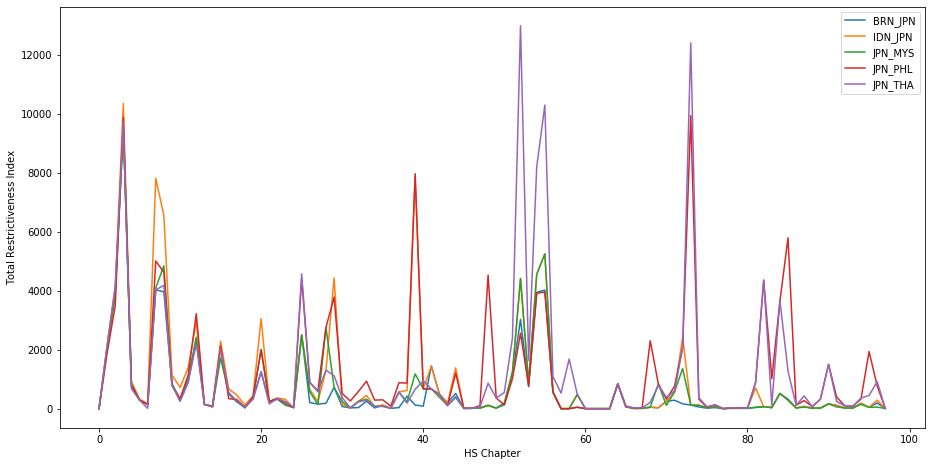

In [287]:
plt.figure(figsize=(15.5,7.75))
for fta in roo:
    # HS 2007
    if fta == 'IND_JPN' or fta == 'JPN_PER':
        continue
    # North america
    if fta == 'CHL_JPN' or fta == 'JPN_MEX':
        continue
    roo[fta].plot_chapter_restrictions()
plt.legend()
    
#plt.plot(range(98), pool['BRN_JPN'])
#plt.plot(range(98), pool['CHL_JPN'])
#plt.plot(range(98), pool['IDN_JPN'])
#plt.plot(range(98), pool['IND_JPN'])
#plt.plot(range(98), pool['JPN_MEX'])
#plt.plot(range(98), pool['JPN_MYS'])
#plt.plot(range(98), pool['JPN_PER'])
#plt.plot(range(98), pool['JPN_PHL'])
#plt.plot(range(98), pool['JPN_THA'])

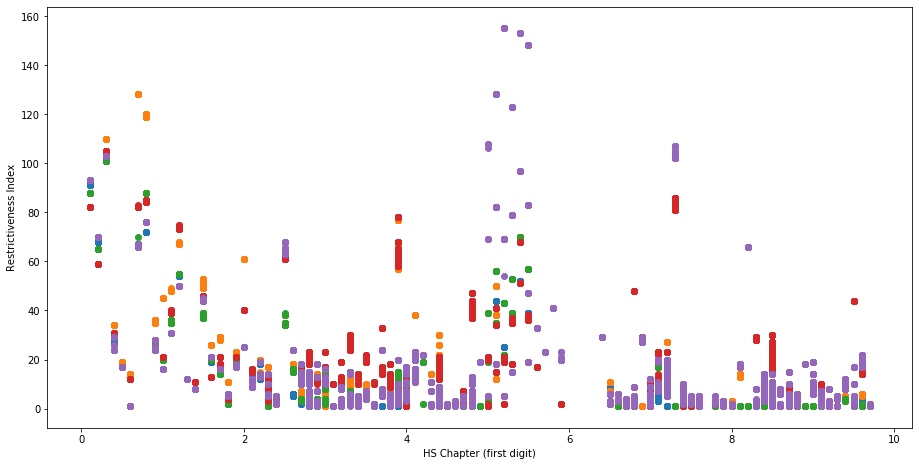

In [288]:
plt.figure(figsize=(15.5,7.75))
for fta in roo:
    # HS 2007
    if fta == 'IND_JPN' or fta == 'JPN_PER':
        continue
    # North america
    if fta == 'CHL_JPN' or fta == 'JPN_MEX':
        pass
        continue
    roo[fta].scatter_plot()
#plt.legend()

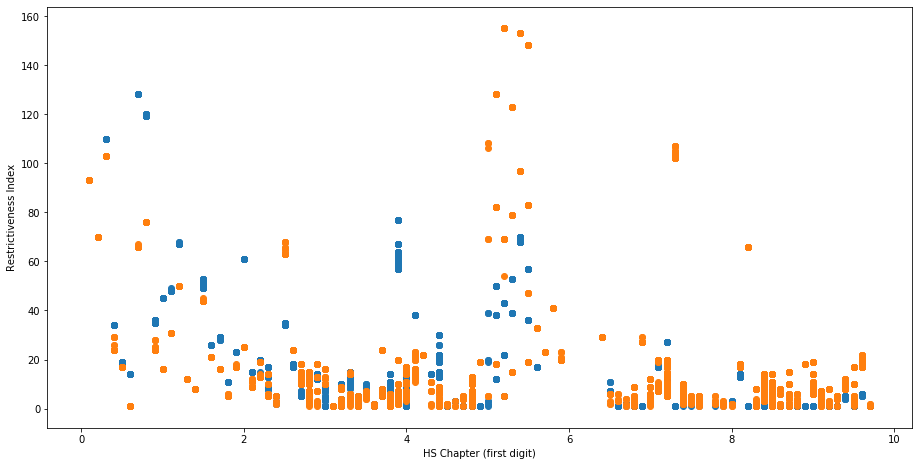

In [232]:
plt.figure(figsize=(15.5,7.75))
roo['IDN_JPN'].scatter_plot()
roo['JPN_THA'].scatter_plot()

In [395]:
heading_restriction = {fta: Counter() for fta in roo}
for fta in roo:
    headings = roo[fta].hs_map.dataframe.loc[roo[fta].hs_map.dataframe['Tier'] == 2, 'ProductCode']
    for heading in headings:
        for hs_code in roo[fta].hs_map.get_hs_codes(heading):
            heading_restriction[fta][heading] += len(roo[fta].get_restrictions().get(hs_code, []))
    #print(fta)
    #pprint.pprint(heading_restriction[fta], width=35)

In [396]:
for key, val in chapter_restriction.items():
    print(key, len(val))

BRN_JPN 96
CHL_JPN 96
IDN_JPN 96
IND_JPN 96
JPN_MEX 96
JPN_MYS 96
JPN_PER 96
JPN_PHL 96
JPN_THA 96


In [303]:
# TRY NEW CHAPTER RESTRICTIONS
roo_rest_new = {fta: {} for fta in roo_restriction_list}
for fta, restrictions in roo_restriction_list.items():
    for hs_code, rest_list in restrictions.items():
        for inter in rest_list:
            roo_rest_new[fta][inter] = roo_rest_new[fta].get(inter, 0) + 1

chapter_restriction = {fta: Counter() for fta in roo_rest_new}
for fta, restrictions in roo_rest_new.items():
    for inter, value in restrictions.items():
        chapter_restriction[fta][inter[:2]] += value

In [ ]:
"""
pprint.pprint(freq, width=35)
print('FTA\t\tChapter\t\tHeading\t\tSubheading\tOther\t\tTotal')
for fta, rules in roo_rules.items():
    total = len(rules)
    try:
        chapter = roo_types_count[fta]['chapter'] / total
        heading = roo_types_count[fta]['heading'] / total
        subheading = roo_types_count[fta]['subheading'] / total
    except:
        continue
    other = 1 - (chapter + heading + subheading)
    print('{}\t\t{:2.2%}\t\t{:2.2%}\t\t{:2.2%}\t\t{:2.2%}\t\t{}'.format(fta, chapter, heading, subheading, other, total))
"""

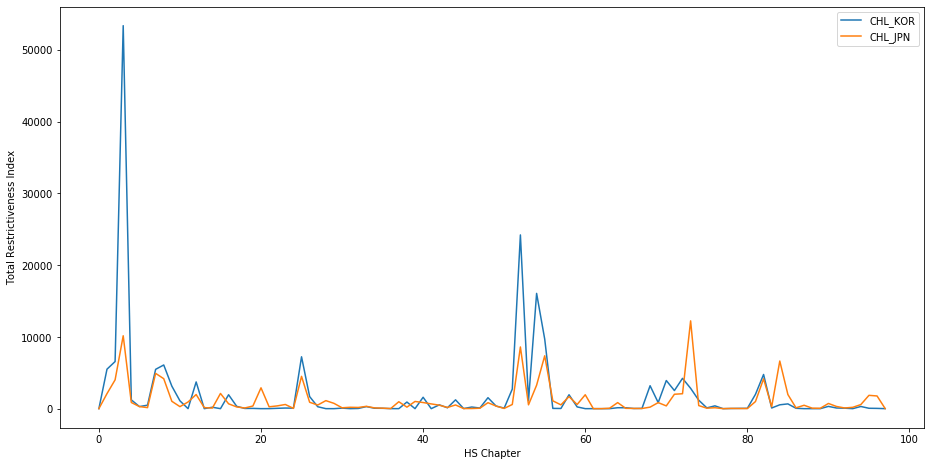

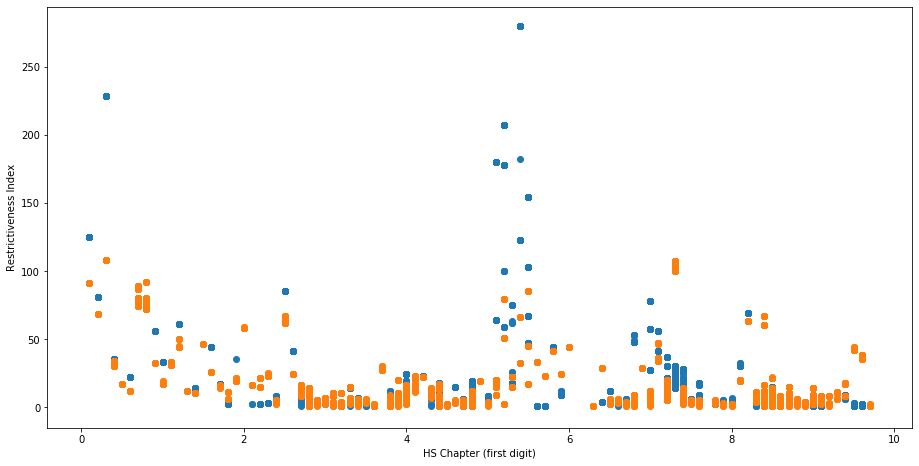

In [289]:
# NEXT PROJECT: KOREA
with open('CHL_KOR.txt', mode='r', encoding='utf-8') as f:
    # Replace en dash with hyphen
    chl_kor = f.read()

CHL_KOR = RoO('CHL_KOR', chl_kor, hs_maps[2017])

plt.figure(figsize=(15.5,7.75))
CHL_KOR.plot_chapter_restrictions()
roo['CHL_JPN'].plot_chapter_restrictions()
plt.legend()

plt.figure(figsize=(15.5,7.75))
CHL_KOR.scatter_plot()
roo['CHL_JPN'].scatter_plot()

# TO-DO: Normalize different versions of HS code

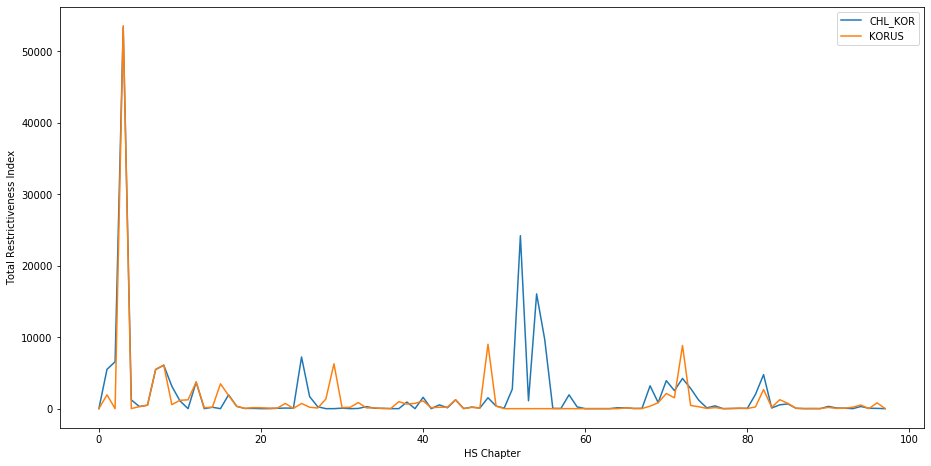

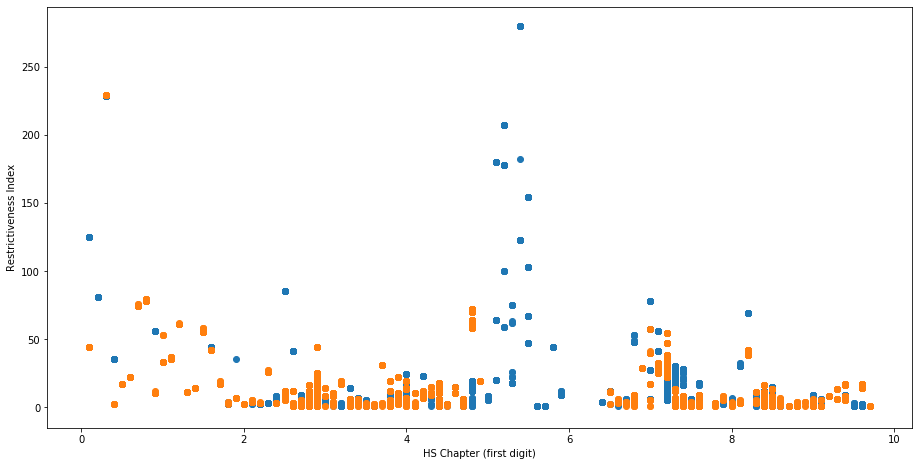

In [290]:
with open('KORUS.txt', mode='r', encoding='utf-8') as f:
    korus = f.read()

KORUS = RoO('KORUS', korus, hs_maps[2017])

plt.figure(figsize=(15.5,7.75))
CHL_KOR.plot_chapter_restrictions()
KORUS.plot_chapter_restrictions()
plt.legend()

plt.figure(figsize=(15.5,7.75))
CHL_KOR.scatter_plot()
KORUS.scatter_plot()

In [291]:
count = 0
for rule in KORUS.get_unique_rules().values():
    res = []
    for pattern in patterns.values():
        res.append(pattern.search(rule))
    if any(res):
        #print(pattern1.search(rule))
        continue
    count += 1
    #print(rule, end='\n\n')
print('Rules left:', count)
    
freq = Counter()
for hsc, rule in KORUS.get_rules().items():
    more = []
    for name, pattern in patterns.items():
        if pattern.search(rule):
            freq[name] += 1
            #break
            more.append(name)
    if len(more) > 1:
        print(more)
        print(rule, end='\n\n')

covered = sum(freq.values())
total = len(KORUS)

print('KORUS')
print('Counter : ', end='')
pprint.pprint(freq.most_common())
print(covered, '/', total, '({:2.2%})'.format(covered / total), end='\n\n')

Rules left: 204
KORUS
Counter : [('CTC', 3717), ('CTCo', 142), ('CTCe', 95), ('CTCoe', 49), ('CTCm', 9)]
4012 / 5053 (79.40%)



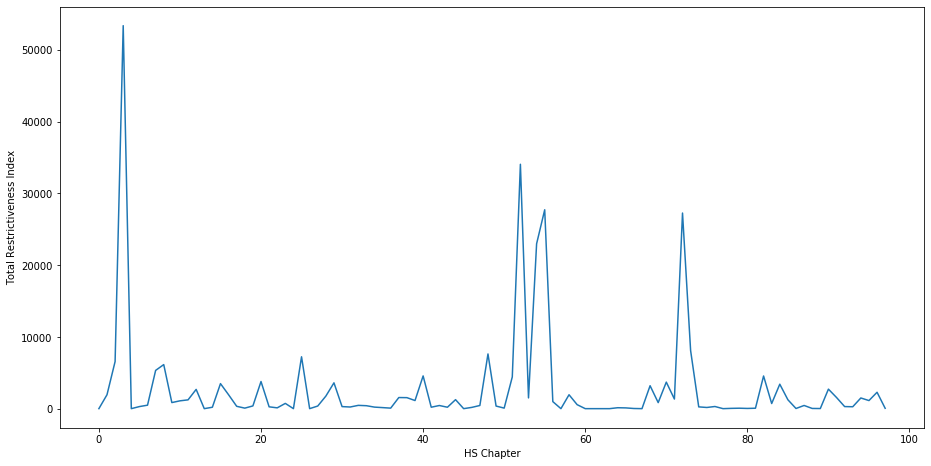

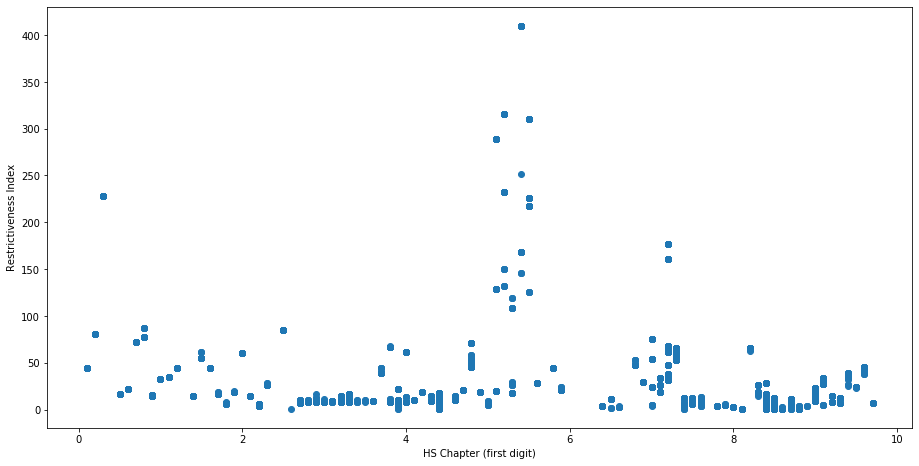

In [292]:
with open('NAFTA_ca.txt', mode='r', encoding='utf-8') as f:
    nafta = f.read()

NAFTA = RoO('NAFTA', nafta, hs_maps[2017])

plt.figure(figsize=(15.5,7.75))
NAFTA.plot_chapter_restrictions()
#KORUS.plot_chapter_restrictions()
#plt.legend()

plt.figure(figsize=(15.5,7.75))
NAFTA.scatter_plot()
#KORUS.scatter_plot()

In [301]:
NAFTA.get_roo_struct().get('Section III')

{'Chapter 15': {'15.01-15.18': 'A change to heading 15.01 through 15.18 from any other chapter, except from heading 38.23.',
  '15.20': 'A change to heading 15.20 from any other heading, except from heading 38.23.',
  '15.21-15.22': 'A change to heading 15.21 through 15.22 from any other chapter.'}}

In [294]:
def do_stuff(ya):
    count = 0
    for rule in NAFTA.get_unique_rules().values():
        res = []
        for pattern in patterns.values():
            res.append(pattern.search(rule))
        if any(res):
            #print(pattern1.search(rule))
            continue
        count += 1
        if ya:
            pass
            print(rule, end='\n\n')
    print('Rules left:', count)

    freq = Counter()
    for hsc, rule in NAFTA.get_rules().items():
        more = []
        for name, pattern in patterns.items():
            if pattern.search(rule):
                freq[name] += 1
                #break
                more.append(name)
                #if name == 'CTCe': print(rule)
        if len(more) > 1:
            print(more)
            print(rule, end='\n\n')

    covered = sum(freq.values())
    total = len(NAFTA)

    print('NAFTA')
    print('Counter : ', end='')
    pprint.pprint(freq.most_common())
    print(covered, '/', total, '({:2.2%})'.format(covered / total), end='\n\n')

In [299]:
# DON'T FORGET TO PASTE THIS BACK
HS_RANGE_TEXT = r'(?:heading|subheading) {0}(?: through {0})?'.format(HS_CODE)
HS_RANGE_TEXT_NC = r'(?:heading|subheading) {0}(?: through {0})?'.format(HS_CODE_NC)
HS_TIER = r'(chapter|heading|subheading)'
HS_TIER_NC = r'(?:[Cc]hapter|heading|subheading)'
CH_NUMBER = r'(\d\d?)\b(?!\.\d)'
CH_NUMBER_NC = r'(?:\d\d?)\b(?!\.\d)'
UNIV_RANGE_TEXT = r'(?:{0}(?: through {0})?|{1}(?: through {1})?)'.format(CH_NUMBER, HS_CODE)
UNIV_RANGE_TEXT_NC = r'(?:{0}(?: through {0})?|{1}(?: through {1})?)'.format(CH_NUMBER_NC, HS_CODE_NC)

# (?: [^;]+? of)?
CTC = r'A change to {0} from any other {1}(?:, including another {2} within that group)?'.format(HS_RANGE_TEXT_NC, HS_TIER, HS_TIER_NC)
CTC_OTG = r'A change to {0} from any(?: other)? {1} outside that group'.format(HS_RANGE_TEXT_NC, HS_TIER)
CTC_ECT = r'A change to {0} from any other {1}, except from {2}'.format(HS_RANGE_TEXT_NC, HS_TIER, MULTI)
CTC_OTG_ECT = r'A change to {0} from any(?: other)? {1} outside that group, except from {2}'.format(HS_RANGE_TEXT_NC, HS_TIER, MULTI)
# CTC1 Multi, need better way
MULTI0 = r'((?:{1}|(?:any )?(?:other )?{0}(?!\.)|within|outside|that group(?!\.)|or|, (?=or|\d)|\s)+)'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
MULTI = r'((?:\s|or|, (?=or|\d)|{0}(?!\.)|{1}|any (?:other )?{0}(?!\.)|within|outside|that group(?!\.))+)'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
CTC1_MULTI = r'A change to {0} from {1}'.format(HS_RANGE_TEXT_NC, MULTI)
CTC2_MULTI = r'A change to {0} from {1}, whether or not there is also a change from any(?: other)? {2}(?: outside that group)?'.format(HS_RANGE_TEXT_NC, MULTI, HS_TIER_NC)
MFTc = r'No required change in tariff classification to {0}, provided(?: that)? non-?originating materials used undergo a chemical reaction(?:, purification, isomer separation or biotechnological processes)? in a Party'.format(HS_RANGE_TEXT_NC)
RVC = r'(?:No(?: required)? change in tariff classification to {0}(?: is required)?, )?provided(?: that)? there is a (?:qualifying|regional) value content of not less than(?:\: a\.)? (\d\d?) per\s?cent(?: under the net cost method| (?:when|where) the (?:[Bb]uild-?down|transaction value) method is used, or (?:of not less than|b\.) (\d\d?) per\s?cent (?:when|where) the (?:[Bb]uild-?up|net cost) method is used)?'.format(HS_RANGE_TEXT_NC)

patterns = {
    'CTC': re.compile(r'^{0}\.$'.format(CTC)),
    'CTC+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC, RVC)),
    'CTCe': re.compile(r'^{0}\.$'.format(CTC_ECT)),
    'CTCo': re.compile(r'^{0}\.$'.format(CTC_OTG)),
    'CTCoe': re.compile(r'^{0}\.$'.format(CTC_OTG_ECT)),
    'CTCm': re.compile(r'^{0}\.$'.format(CTC1_MULTI)),
    
    'CTC_or_RVC': re.compile(r'^{0}; or {1}\.$'.format(CTC, RVC)),
    'CTC_or_MFTc': re.compile(r'^{0}; or {1}\.$'.format(CTC, MFTc)),
    'CTC_or_RVC_or_MFTc': re.compile(r'^{0}; {1}; or {2}\.$'.format(CTC, RVC, MFTc)),
    'CTCe_or_RVC': re.compile(r'^{0}; or {1}\.$'.format(CTC_ECT, RVC)),
    
    'CTC1_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC, CTC2_MULTI, RVC)),
    'CTC1o_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_OTG, CTC2_MULTI, RVC)),
    'CTC1e_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_ECT, CTC2_MULTI, RVC)),
    'CTC1oe_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_OTG_ECT, CTC2_MULTI, RVC)),

    'CTC1_EXC_or_CTC2m+RVC': re.compile(r'^A change to {0} from {2} or any other {1}; or A change to {0} from {2}, whether or not there is also a change from {0} or any other {3}, {4}\.$'.format(HS_RANGE_TEXT_NC, HS_TIER, HS_RANGE_TEXT, HS_TIER_NC, RVC)),
    
    'RVC': re.compile(r'^(?:{0}|A qualifying value content of not less than \d\d? percent)\.$'.format(RVC)),
    'WO': re.compile(r'^(?:Manufacture in which all the materials used are wholly obtained\.|Goods of (?:heading|subheading) {0}(?: through {0})? are wholly obtained or produced entirely in a Party\,? as defined in Article \d\d?\.)$'.format(HS_CODE_NC)),
    'WO_scrap': re.compile(r'^No required change in tariff classification to {0}, provided(?: that)? the waste(?: and scrap are)?(?: is)? wholly obtained or produced entirely in (?:a Party|the Area of one or both Parties|the territory of a Country) as defined in Article \d\d?(?: of Chapter \d\d?)?\.$'.format(HS_RANGE_TEXT_NC)),
    
    'Manufacture': re.compile(r'^Manufacture from (?:yarns|fibres|fabrics|chemical materials or textile pulps)(?:, provided that necessary process stipulated in the Appendix is undertaken)?\.$'),

    'CTC+asean': re.compile(r'^{0}, provided? that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[^;]+) in (?:(?:either Party or )?a non-?Party|the territory of either Country or a third State) which is a member country of the ASEAN\.$'.format(CTC)),
    'CTCo+asean': re.compile(r'^{0}, provided that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[^;]+) in either Party or a non-?Party which is a member country of the ASEAN\.$'.format(CTC_OTG)),
    'CTC+asean_or_Manufacture': re.compile(r'^{0}, provided? that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN; or No required change in tariff classification to {1}, provided that the good is (?:[\w\W]+) and that the non-?originating material of that group is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN.$'.format(CTC, HS_RANGE_TEXT_NC)),
    'CTCo+asean_or_Manufacture': re.compile(r'^{0}, provided that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN; or No required change in tariff classification to {1}, provided that the good is (?:[\w\W]+) and that the non-?originating material of that group is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN.$'.format(CTC_OTG, HS_RANGE_TEXT_NC)),
    
    'CC_fishing': re.compile(r'^A change to {0} from any other chapter, provided that, where non-originating materials of (?:[\w\W]+) are used, each of the non-originating materials is (?:obtained by fishing) in a non-?Party which is a member country of the ASEAN or taken by vessels, which are registered in and sail under the flag of a non-Party which is a member country of the ASEAN, from the sea outside the territorial sea of that non-Party\.$'.format(HS_RANGE_TEXT_NC)),
    
    'pattern_1': re.compile(r'^All the animals of Chapter 1 shall be wholly obtained\.$')
}

do_stuff(1)

A change to heading 04.01 through 04.10 from any other chapter, except from tariff item 1901.90.aa.

A change to savory, crushed or ground, of subheading 0712.90 from savory, neither crushed nor ground, of subheading 0712.90 or any other chapter; or A change to any other good of subheading 0712.90 from any other chapter.

A change to allspice, crushed or ground, of subheading 0904.20 from allspice, neither crushed nor ground, of subheading 0904.20 or any other chapter; or A change to any other good of subheading 0904.20 from any other chapter.

A change to a good of heading 09.07 from within that heading or any other chapter.

A change to a good of any of subheading 0908.10 through 0909.50 from within that subheading or any other chapter.

A change to a good of subheading 0910.10 from within that subheading or any other chapter.

A change to a good of subheading 0910.30 from within that subheading or any other chapter.

Note: Notwithstanding paragraph 5, Article 405: De Minimis, paragr

NAFTA
Counter : [('CTC', 2472),
 ('CTCe', 537),
 ('CTC1_or_CTC2m+RVC', 522),
 ('CTCo', 382),
 ('CTC+RVC', 188),
 ('CTCoe', 186),
 ('CTC1e_or_CTC2m+RVC', 81),
 ('CTC1oe_or_CTC2m+RVC', 72),
 ('CTC_or_RVC', 52),
 ('CTC1o_or_CTC2m+RVC', 4)]
4496 / 5866 (76.65%)

